<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/linreg_hierarchical_non_centered_numpyro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



#  Hierarchical non-centered Bayesian Linear Regression in NumPyro

The text and code for this notebook are taken directly from [this blog post](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/)
 by Thomas Wiecki. [Original notebook](https://github.com/twiecki/WhileMyMCMCGentlySamples/blob/master/content/downloads/notebooks/GLM_hierarchical_non_centered.ipynb)
 



In [1]:
!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro arviz
!pip install arviz
!pip install seaborn

First, we will import the libraries we need to:

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from jax import random

sns.set_style("whitegrid")
np.random.seed(123)

Then, we'll load the data: 

In [3]:
url = "https://github.com/twiecki/WhileMyMCMCGentlySamples/blob/master/content/downloads/notebooks/radon.csv?raw=true"
data = pd.read_csv(url)

In [4]:
county_names = data.county.unique()
county_idx = data.county_code.values

## The intuitive specification

Usually, hierachical models are specified in a *centered* way. In a regression model, individual slopes would be centered around a group mean with a certain group variance, which controls the shrinkage:

In [7]:
def hierarchical_model_centered(county_idx, floor, log_of_radon):
    # Hyperpriors
    mu_a = numpyro.sample("mu_a", dist.Normal(0.0, 100**2))
    sigma_a = numpyro.sample("sigma_a", dist.HalfCauchy(5.0))
    mu_b = numpyro.sample("mu_b", dist.Normal(0.0, 100**2))
    sigma_b = numpyro.sample("sigma_b", dist.HalfCauchy(5.0))

    unique_counties = np.unique(county_idx)
    n_counties = len(unique_counties)

    with numpyro.plate("counties", n_counties):
        # Intercept for each county, distributed around group mean mu_a
        a = numpyro.sample("a", dist.Normal(mu_a, sigma_a))
        # Intercept for each county, distributed around group mean mu_a
        b = numpyro.sample("b", dist.Normal(mu_b, sigma_b))

    # Model error
    eps = numpyro.sample("eps", dist.HalfCauchy(scale=5.0))
    # Expected value
    radon_est = a[county_idx] + b[county_idx] * floor

    with numpyro.plate("data", len(county_idx)):
        # Data likelihood
        numpyro.sample("obs", dist.Normal(radon_est, eps), obs=log_of_radon)

In [8]:
nuts_kernel = NUTS(hierarchical_model_centered)
mcmc = MCMC(nuts_kernel, num_samples=5000, num_warmup=1000, num_chains=2)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, county_idx, data.floor.values, data.log_radon.values)

hierarchical_centered_trace = mcmc.get_samples(True)
# Eliminates the first 1000 samples
hierarchical_centered_trace = {
    k: v[:, 1000:, :] if len(v.shape) == 3 else v[:, 1000:] for k, v in hierarchical_centered_trace.items()
}

/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 6000/6000 [00:09<00:00, 664.28it/s, 31 steps of size 1.40e-01. acc. prob=0.78]


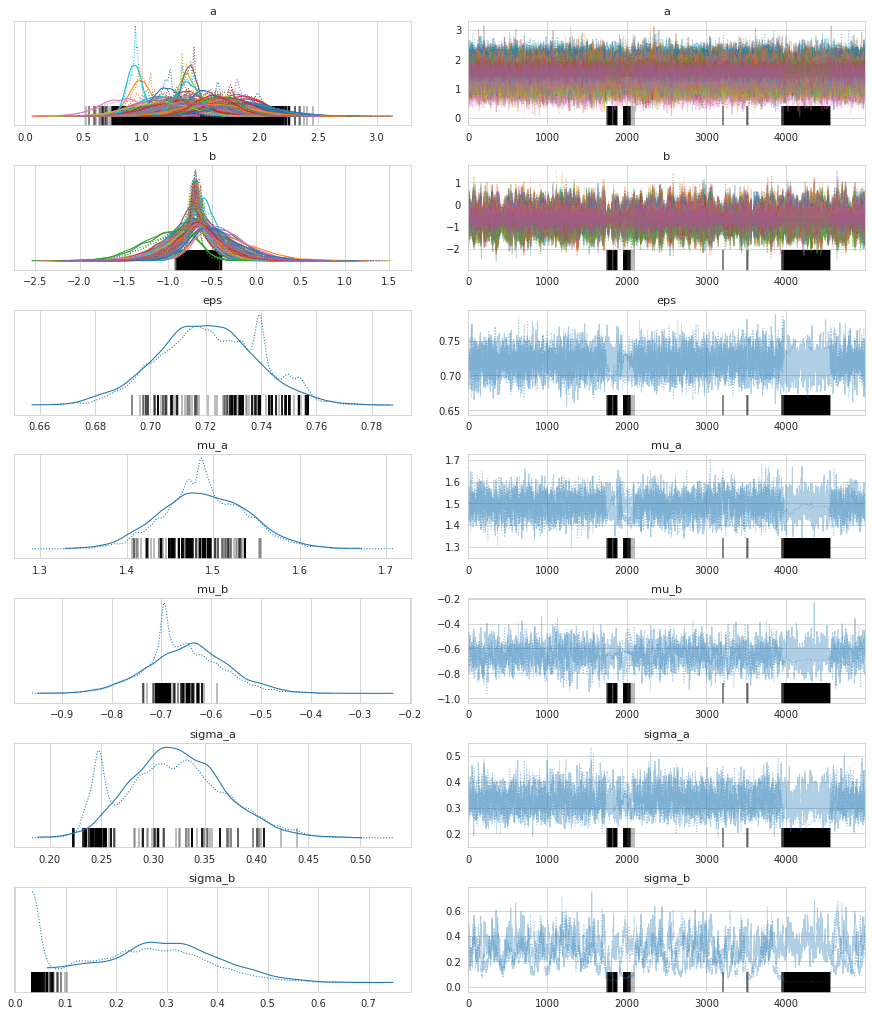

In [9]:
inference_data = az.from_numpyro(mcmc)
az.plot_trace(inference_data, compact=True);

I have seen plenty of traces with terrible convergences but this one might look fine to the unassuming eye. Perhaps `sigma_b` has some problems, so let's look at the Rhat:

In [12]:
print("Rhat(sigma_b) = {}".format(numpyro.diagnostics.gelman_rubin(hierarchical_centered_trace["sigma_b"])))

Rhat(sigma_b) = 1.0568724870681763


Not too bad -- well below 1.1. I used to think this wasn't a big deal but Michael Betancourt in his [StanCon 2017 talk](https://www.youtube.com/watch?v=DJ0c7Bm5Djk&feature=youtu.be&t=4h40m9s) makes a strong point that it is actually very problematic. To understand what's going on, let's take a closer look at the slopes `b` and their group variance (i.e. how far they are allowed to move from the mean) `sigma_b`. I'm just plotting a single chain now.

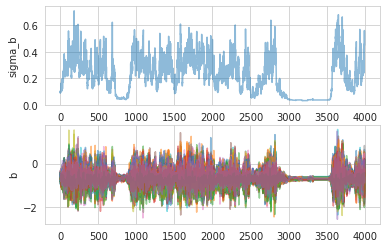

In [13]:
fig, axs = plt.subplots(nrows=2)
axs[0].plot(hierarchical_centered_trace["sigma_b"][1], alpha=0.5)
axs[0].set(ylabel="sigma_b")
axs[1].plot(hierarchical_centered_trace["b"][1], alpha=0.5)
axs[1].set(ylabel="b");

`sigma_b` seems to drift into this area of very small values and get stuck there for a while. This is a common pattern and the sampler is trying to tell you that there is a region in space that it can't quite explore efficiently.  While stuck down there, the slopes `b_i` become all squished together. We've entered **The Funnel of Hell** (it's just called the funnel, I added the last part for dramatic effect).

## The Funnel of Hell (and how to escape it)

Let's look at the joint posterior of a single slope `b` (I randomly chose the 75th one) and the slope group variance `sigma_b`.

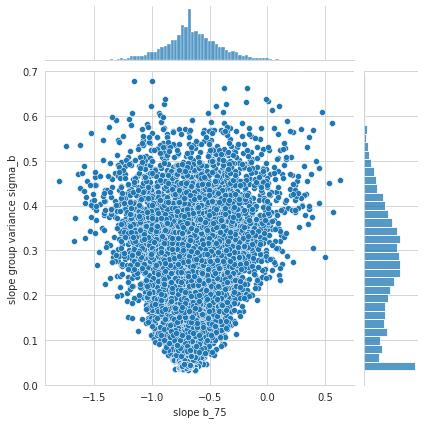

In [14]:
x = pd.Series(hierarchical_centered_trace["b"][:, :, 75].flatten(), name="slope b_75")
y = pd.Series(hierarchical_centered_trace["sigma_b"][:, :].flatten(), name="slope group variance sigma_b")

sns.jointplot(x=x, y=y, ylim=(0, 0.7));

This makes sense, as the slope group variance goes to zero (or, said differently, we apply maximum shrinkage), individual slopes are not allowed to deviate from the slope group mean, so they all collapose to the group mean.

While this property of the posterior in itself is not problematic, it makes the job extremely difficult for our sampler. Imagine a [Metropolis-Hastings](https://twiecki.github.io/blog/2015/11/10/mcmc-sampling/) exploring this space with a medium step-size (we're using NUTS here but the intuition works the same): in the wider top region we can comfortably make larger jumps to explore the space efficiently. However, once we move to the narrow bottom region we can change `b_75` and `sigma_b` only by tiny amounts. This causes the sampler to become trapped in that region of space. Most of the proposals will be rejected because our step-size is too large for this narrow part of the space and exploration will be very inefficient.

You might wonder if we could somehow choose the step-size based on the denseness (or curvature) of the space. Indeed that's possible and it's called [Riemannian HMC](https://arxiv.org/abs/0907.1100). It works very well but is quite costly to run. Here, we will explore a different, simpler method.

Finally, note that this problem does not exist for the intercept parameters `a`. Because we can determine individual intercepts `a_i` with enough confidence, `sigma_a` is not small enough to be problematic. Thus, the funnel of hell can be a problem in hierarchical models, but it does not have to be. (Thanks to John Hall for pointing this out).


## Reparameterization

If we can't easily make the sampler step-size adjust to the region of space, maybe we can adjust the region of space to make it simpler for the sampler? This is indeed possible and quite simple with a small reparameterization trick, we will call this the *non-centered* version.

In [15]:
def hierarchical_model_non_centered(county_idx, floor, log_of_radon):
    # Hyperpriors
    mu_a = numpyro.sample("mu_a", dist.Normal(0.0, 100**2))
    sigma_a = numpyro.sample("sigma_a", dist.HalfCauchy(5.0))
    mu_b = numpyro.sample("mu_b", dist.Normal(0.0, 100**2))
    sigma_b = numpyro.sample("sigma_b", dist.HalfCauchy(5.0))

    unique_counties = np.unique(county_idx)
    n_counties = len(unique_counties)

    with numpyro.plate("counties", n_counties):
        # Intercept for each county, distributed around group mean mu_a
        a_offset = numpyro.sample("a_offset", dist.Normal(0, 1))
        a = numpyro.deterministic("a", mu_a + a_offset * sigma_a)
        # Intercept for each county, distributed around group mean mu_a
        b_offset = numpyro.sample("b_offset", dist.Normal(0, 1))
        b = numpyro.deterministic("b", mu_b + b_offset * sigma_b)

    # Model error
    eps = numpyro.sample("eps", dist.HalfCauchy(scale=5.0))
    # Expected value
    radon_est = a[county_idx] + b[county_idx] * floor

    with numpyro.plate("data", len(county_idx)):
        # Data likelihood
        numpyro.sample("obs", dist.Normal(radon_est, eps), obs=log_of_radon)

In [16]:
nuts_kernel = NUTS(hierarchical_model_non_centered)
mcmc = MCMC(nuts_kernel, num_samples=5000, num_warmup=1000, num_chains=2)
mcmc.run(rng_key, county_idx, data.floor.values, data.log_radon.values)

hierarchical_non_centered_trace = mcmc.get_samples(True)
hierarchical_non_centered_trace = {
    k: v[:, 1000:, :] if len(v.shape) == 3 else v[:, 1000:] for k, v in hierarchical_non_centered_trace.items()
}

/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 6000/6000 [00:09<00:00, 630.12it/s, 31 steps of size 1.71e-01. acc. prob=0.91]


Pay attention to the definitions of `a_offset`, `a`, `b_offset`, and `b` and compare them to before (commented out). What's going on here? It's pretty neat actually. Instead of saying that our individual slopes `b` are normally distributed around a group mean (i.e. modeling their absolute values directly), we can say that they are offset from a group mean by a certain value (`b_offset`; i.e. modeling their values relative to that mean). Now we still have to consider how far from that mean we actually allow things to deviate (i.e. how much shrinkage we apply). This is where `sigma_b` makes a comeback. We can simply multiply the offset by this scaling factor to get the same effect as before, just under a different parameterization. For a more formal introduction, see e.g. [Betancourt & Girolami (2013)](https://arxiv.org/pdf/1312.0906.pdf).

Critically, `b_offset` and `sigma_b` are now mostly independent. This will become more clear soon. Let's first look at if this transform helped our sampling:

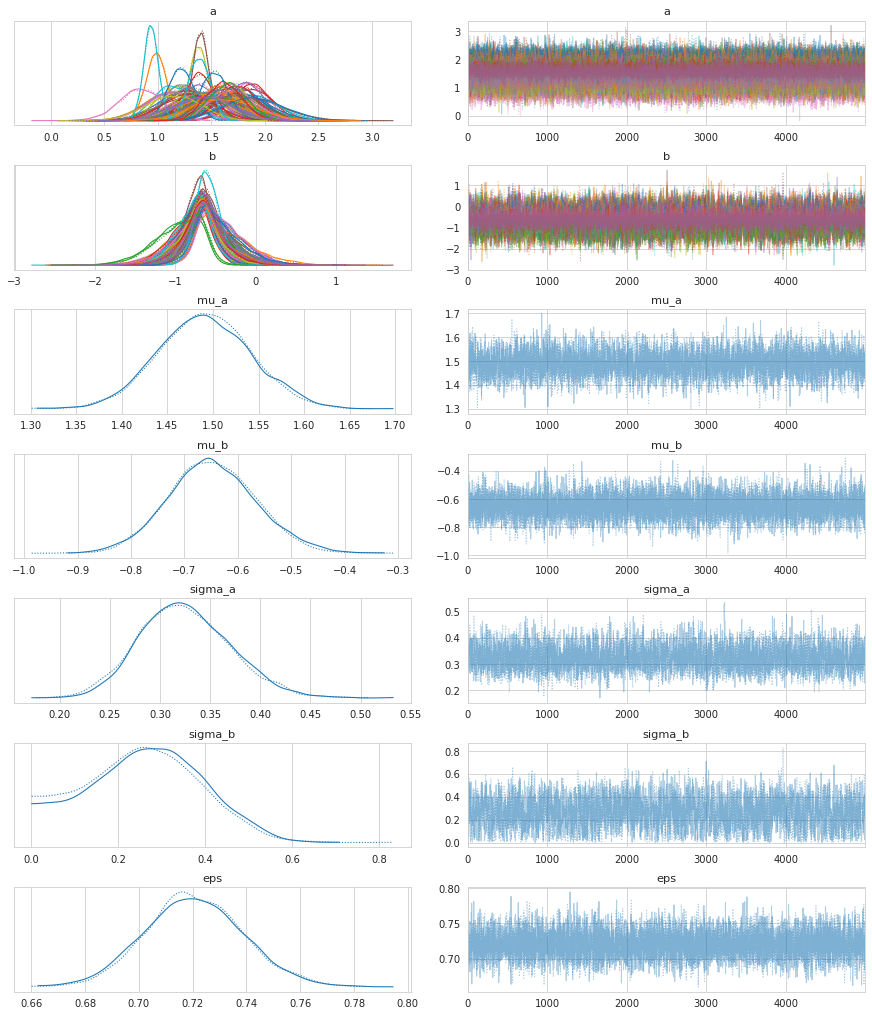

In [17]:
var_names = ["a", "b", "mu_a", "mu_b", "sigma_a", "sigma_b", "eps"]
inference_data = az.from_numpyro(mcmc)
az.plot_trace(inference_data, var_names=var_names, compact=True);

That looks much better as also confirmed by the joint plot:

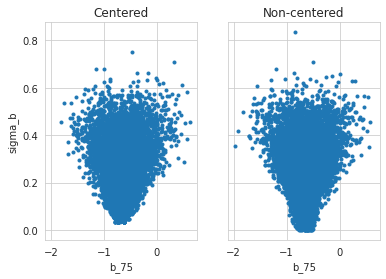

In [18]:
fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True)

x = pd.Series(hierarchical_centered_trace["b"][:, :, 75].flatten(), name="slope b_75")
y = pd.Series(hierarchical_centered_trace["sigma_b"][:, :].flatten(), name="slope group variance sigma_b")

axs[0].plot(x, y, ".")
axs[0].set(title="Centered", ylabel="sigma_b", xlabel="b_75")

x = pd.Series(hierarchical_non_centered_trace["b"][:, :, 75].flatten(), name="slope b_75")
y = pd.Series(hierarchical_non_centered_trace["sigma_b"].flatten(), name="slope group variance sigma_b")

axs[1].plot(x, y, ".")
axs[1].set(title="Non-centered", xlabel="b_75");

To really drive this home, let's also compare the `sigma_b` marginal posteriors of the two models:

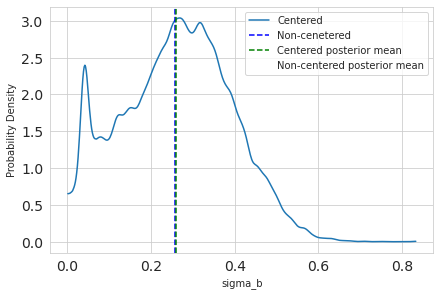

In [19]:
az.plot_kde(
    np.stack(
        [
            hierarchical_centered_trace["sigma_b"],
            hierarchical_non_centered_trace["sigma_b"],
        ]
    ).T
)
plt.axvline(hierarchical_centered_trace["sigma_b"].mean(), color="b", linestyle="--")
plt.axvline(hierarchical_non_centered_trace["sigma_b"].mean(), color="g", linestyle="--")
plt.legend(["Centered", "Non-cenetered", "Centered posterior mean", "Non-centered posterior mean"])
plt.xlabel("sigma_b")
plt.ylabel("Probability Density");

That's crazy -- there's a large region of very small `sigma_b` values that the sampler could not even explore before. In other words, our previous inferences ("Centered") were severely biased towards higher values of `sigma_b`. Indeed, if you look at the [previous blog post](https://twiecki.github.io/blog/2014/03/17/bayesian-glms-3/) the sampler never even got stuck in that low region causing me to believe everything was fine. These issues are hard to detect and very subtle, but they are meaningful as demonstrated by the sizable difference in posterior mean.

But what does this concretely mean for our analysis? Over-estimating `sigma_b` means that we have a biased (=false) belief that we can tell individual slopes apart better than we actually can. There is less information in the individual slopes than what we estimated.

### Why does the reparameterized model work better?

To more clearly understand why this model works better, let's look at the joint distribution of `b_offset`:

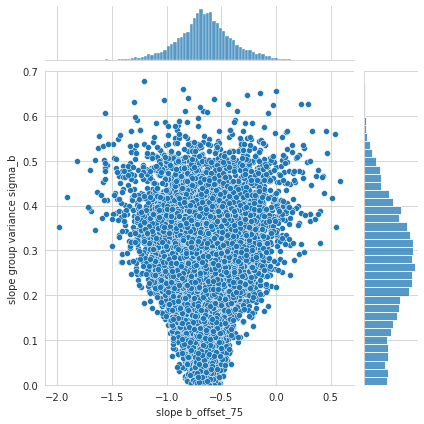

In [20]:
x = pd.Series(hierarchical_non_centered_trace["b"][:, :, 75].flatten(), name="slope b_offset_75")
y = pd.Series(hierarchical_non_centered_trace["sigma_b"][:, :].flatten(), name="slope group variance sigma_b")

sns.jointplot(x=x, y=y, ylim=(0, 0.7));

This is the space the sampler sees; you can see how the funnel is flattened out. We can freely change the (relative) slope offset parameters even if the slope group variance is tiny as it just acts as a scaling parameter.

Note that the funnel is still there -- it's a perfectly valid property of the model -- but the sampler has a much easier time exploring it in this different parameterization.

## Why hierarchical models are Bayesian

Finally, I want to take the opportunity to make another point that is not directly related to hierarchical models but can be demonstrated quite well here.

Usually when talking about the perils of Bayesian statistics we talk about priors, uncertainty, and flexibility when coding models using Probabilistic Programming. However, an even more important property is rarely mentioned because it is much harder to communicate. Ross Taylor touched on this point in his tweet:

<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">It&#39;s interesting that many summarize Bayes as being about priors; but real power is its focus on integrals/expectations over maxima/modes</p>&mdash; Ross Taylor (@rosstaylor90) <a href="https://twitter.com/rosstaylor90/status/827263854002401281">February 2, 2017</a></blockquote>
<script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>

Michael Betancourt makes a similar point when he says ["Expectations are the only thing that make sense."](https://www.youtube.com/watch?v=pHsuIaPbNbY&t=8s)

But what's wrong with maxima/modes? Aren't those really close to the posterior mean (i.e. the expectation)? Unfortunately, that's only the case for the simple models we teach to build up intuitions. In complex models, like the hierarchical one, the MAP can be far away and not be interesting or meaningful at all.

Let's compare the posterior mode (i.e. the MAP) to the posterior mean of our hierachical linear regression model:

In [21]:
hierarchical_centered_trace["b"].reshape(8000, -1).mean(axis=0)

DeviceArray([-0.61775804, -0.784016  , -0.6444629 , -0.684291  ,
             -0.6175344 , -0.6526325 , -0.43086374, -0.62683606,
             -0.48724282, -0.71894264, -0.6584481 , -0.65013456,
             -0.64767295, -0.71897113, -0.6480633 , -0.6510828 ,
             -0.7734428 , -0.5343285 , -0.73611844, -0.6512574 ,
             -0.6120353 , -0.67254245, -0.63207006, -0.6442637 ,
             -0.4420492 , -0.7308663 , -0.60087   , -0.63911474,
             -0.65216845, -0.6527322 , -0.65545297, -0.6493428 ,
             -0.65607816, -0.6761536 , -0.61533874, -0.49691164,
             -0.63680613, -0.5907634 , -0.59068084, -0.6441326 ,
             -0.5506559 , -0.6510959 , -0.9749179 , -0.7988832 ,
             -0.7645598 , -0.65044665, -0.8073655 , -0.5840309 ,
             -0.8212928 , -0.6522961 , -0.6491905 , -0.64879245,
             -0.68533814, -0.8224224 , -0.5737109 , -0.77026623,
             -0.68192047, -0.59168494, -0.71270126, -0.6526965 ,
             -0.44736174,

In [22]:
hierarchical_centered_trace["sigma_b"].reshape(1, -1).std(axis=1)

DeviceArray([0.12972713], dtype=float32)

As you can see, the slopes are all identical and the group slope variance is effectively zero. The reason is again related to the funnel. The MAP only cares about the probability **density** which is highest at the bottom of the funnel. 

But if you could only choose one point in parameter space to summarize the posterior above, would this be the one you'd pick? Probably not.

Let's instead look at the **Expected Value** (i.e. posterior mean) which is computed by integrating probability **density** and **volume** to provide probabilty **mass** -- the thing we really care about. Under the hood, that's the integration performed by the MCMC sampler.

In [23]:
hierarchical_non_centered_trace["b"].reshape(8000, -1).mean(axis=0)

DeviceArray([-0.60958904, -0.77637196, -0.63716346, -0.68550086,
             -0.61252284, -0.6484182 , -0.42712796, -0.6194832 ,
             -0.4907205 , -0.72019935, -0.65286654, -0.6524814 ,
             -0.6453997 , -0.7145038 , -0.64827716, -0.64544415,
             -0.77342564, -0.5318868 , -0.7338742 , -0.64709485,
             -0.60045236, -0.66165376, -0.6282897 , -0.641589  ,
             -0.4422077 , -0.72659   , -0.5974192 , -0.63555014,
             -0.64612347, -0.6486698 , -0.64841944, -0.6495775 ,
             -0.6544013 , -0.6757745 , -0.61307794, -0.4923236 ,
             -0.62987775, -0.58239734, -0.5822784 , -0.6359232 ,
             -0.5402708 , -0.64885145, -0.9741085 , -0.79671675,
             -0.75808036, -0.65145695, -0.81187296, -0.58565944,
             -0.81828624, -0.6482773 , -0.64527243, -0.65161073,
             -0.6775216 , -0.82358456, -0.57393545, -0.7748496 ,
             -0.6730962 , -0.58360213, -0.7100343 , -0.64674795,
             -0.44087234,

In [24]:
hierarchical_non_centered_trace["sigma_b"].reshape(1, -1).mean(axis=1)

DeviceArray([0.26020268], dtype=float32)

Quite a difference. This also explains why it can be a bad idea to use the MAP to initialize your sampler: in certain models the MAP is not at all close to the region you want to explore (i.e. the "typical set"). 

This strong divergence of the MAP and the Posterior Mean does not only happen in hierarchical models but also in high dimensional ones, where our intuitions from low-dimensional spaces gets twisted in serious ways. [This talk by Michael Betancourt](https://www.youtube.com/watch?v=pHsuIaPbNbY&t=8s) makes the point quite nicely.

So why do people -- especially in Machine Learning -- still use the MAP/MLE? As we all learned in high school first hand, integration is much harder than differentation. This is really the only reason.

Final disclaimer: This might provide the impression that this is a property of being in a Bayesian framework, which is not true. Technically, we can talk about Expectations vs Modes irrespective of that. Bayesian statistics just happens to provide a very intuitive and flexible framework for expressing and estimating these models.

See [here](https://rawgithub.com/twiecki/WhileMyMCMCGentlySamples/master/content/downloads/notebooks/GLM_hierarchical_non_centered.ipynb) for the underlying notebook of this blog post.

## Acknowledgements

Thanks to [Jon Sedar](https://twitter.com/jonsedar) for helpful comments on an earlier draft.